In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# import PFAS-proximal mordred + phenolic dataset
bcf_prox = pd.read_csv('data/bcf_mordred_prox.csv', index_col=0)

In [17]:
# Transfer learning data preparation

# Partition into: training dataset, target (transfer) dataset, global pfas dataset
def get_data(dataframe, target_label, pfas_label, head_columns):
    df_pfas = dataframe[dataframe[pfas_label] == True]
    df_target = dataframe[dataframe[target_label] == True]
    df_training = dataframe[(dataframe[pfas_label] == False) & (dataframe[target_label] == False)]

    head_columns.extend([target_label, pfas_label])
    # pfas final validation set only
    data1 = df_pfas.drop(columns=head_columns, axis=1)

    # pfas transfer prox set only
    data2 = df_target.drop(columns=head_columns, axis=1)

    # base training set only
    data3 = df_training.drop(columns=head_columns, axis=1)

    y_pfas = data1.pop('logBCF').to_numpy()
    X_pfas = data1.to_numpy()

    y_target = data2.pop('logBCF').to_numpy()
    X_target = data2.to_numpy()

    y_train = data3.pop('logBCF').to_numpy()
    X_train = data3.to_numpy()
    
    train = (X_train, y_train)
    target = (X_target, y_target)
    pfas = (X_pfas, y_pfas)
    
    return train, target, pfas

# .reshape(-1, 1) due to y not being in single column form, sklearn does not like it
# hopefully this formatting change does not interfere with predictions

p_train, p_target, p_pfas = get_data(bcf_prox, 'is_pfas_prox_p', 'is_pfas', 
                               ['CAS', 'Dataset', 'cSMILES', 'rd_mol', 'cf_bonds', 'is_pfas_prox_m'])

# X_train, y_train = p_train
# X_target, y_target = p_target
# X_pfas, y_pfas = p_pfas

m_train, m_target, m_pfas = get_data(bcf_prox, 'is_pfas_prox_m', 'is_pfas', 
                          ['CAS', 'Dataset', 'cSMILES', 'rd_mol', 'cf_bonds', 'is_pfas_prox_p'])

# X_train, y_train = m_train
# X_target, y_target = m_target
# X_pfas, y_pfas = m_pfas

In [22]:
# CF bonds transfer set
def get_cf_data(dataframe, pfas_label, head_columns):
    df_pfas = dataframe[dataframe[pfas_label] == True]
    df_target = dataframe[(dataframe['cf_bonds'] >= 2) & (dataframe[pfas_label] == False)]
    df_training = dataframe[(dataframe['cf_bonds'] < 2) & (dataframe[pfas_label] == False)]

    head_columns.extend([pfas_label])
    # pfas final validation set only
    data1 = df_pfas.drop(columns=head_columns, axis=1)

    # pfas transfer prox set only
    data2 = df_target.drop(columns=head_columns, axis=1)

    # base training set only
    data3 = df_training.drop(columns=head_columns, axis=1)

    y_pfas = data1.pop('logBCF').to_numpy()
    X_pfas = data1.to_numpy()

    y_target = data2.pop('logBCF').to_numpy()
    X_target = data2.to_numpy()

    y_train = data3.pop('logBCF').to_numpy()
    X_train = data3.to_numpy()
    
    train = (X_train, y_train)
    target = (X_target, y_target)
    pfas = (X_pfas, y_pfas)
    
    return train, target, pfas
    
cf_train, cf_target, cf_pfas = get_cf_data(bcf_prox, 'is_pfas', 
                          ['CAS', 'Dataset', 'cSMILES', 'rd_mol', 'cf_bonds', 'is_pfas_prox_p', 'is_pfas_prox_m'])

X_train, y_train = cf_train
X_target, y_target = cf_target
X_pfas, y_pfas = cf_pfas

In [6]:
class DNN(keras.Model):
    
    # can use __init__ to instantiate architecture, usually done this way
    # pass arguments array to init, and in init take out private variable initialization
    def __init__(self, n_layers=4, layer_size=200, batch_size=250, learning_rate=0.01, epochs=1000, seed=100):
        super().__init__()
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.seed = seed
        self.generate()
    
    def generate(self):
        self.pipeline = []
        
        for i, layer in enumerate(range(self.n_layers)):
            # batch normalization improves stability of model
            self.pipeline.append(layers.BatchNormalization())
            self.pipeline.append(layers.Dense(self.layer_size, activation='relu'))
            
        self.pipeline.append(layers.BatchNormalization())
        self.pipeline.append(layers.Dense(1, activation = 'linear'))
        
    def call(self, inputs):
        x = inputs
        for layer in self.pipeline:
            x = layer(x)
            
        return x
        
    def fit(self, x_train, y_train, **kwargs):
        tf.random.set_seed(self.seed)
        
        # build creates input layer based on training data shape
        super().build(input_shape=x_train.shape)
        super().compile(optimizer=keras.optimizers.Adam(self.learning_rate), loss='mean_absolute_error', 
                        metrics=['mse', 'mae'])
        return super().fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, **kwargs)
    
# for reinitializing layers
def init_layer(layer):
    #where are the initializers?
    if hasattr(layer, 'cell'):
        init_container = layer.cell
    else:
        init_container = layer

    for key, initializer in init_container.__dict__.items():
        if "initializer" not in key: #is this item an initializer?
                continue #if no, skip it

        # find the corresponding variable, like the kernel or the bias
        if key == 'recurrent_initializer': #special case check
            var = getattr(init_container, 'recurrent_kernel')
        else:
            var = getattr(init_container, key.replace("_initializer", ""))

        var.assign(initializer(var.shape, var.dtype))

# print out all validation metrics
def summarize(title, val, global_val):
    print('--------------------')
    print(title)
    print('Cross-Validation Metrics:')
    print('--------------------')
    print('Mean r2:', np.mean(val['r2']))
    print('Mean mae:', np.mean(val['mae']))
    print('Mean rmse:', np.mean(val['rmse']), '\n')
    
    print('PFAS Ensemble Metrics:')
    print('--------------------')
    print('r2:', global_val['r2'][0])
    print('mae:', global_val['mae'][0])
    print('rmse:', global_val['rmse'][0])

In [7]:
# train optimized base model for transfer learning
# ensemble of 5 models used for global validation

# tag is identifier for specific target set
def base_dnn(X, y, X_target, y_target, X_pfas, y_pfas, export=True, tag=''):
    ensemble1 = []
    ensemble2 = []
    scalers = []
    validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    global_validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=200)
    for fold_no, (train, test) in enumerate(kf.split(X)):
        print("Starting: Fold", fold_no)
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        
        X_scaler = StandardScaler()
        X_scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        X_target_scaled = X_scaler.transform(X_target)
        X_pfas_scaled = X_scaler.transform(X_pfas)
        
        y_scaler = StandardScaler()
        y_scaler.fit(y_train.reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
        
        # export scalers for transfer learning model
        scalers.append((X_scaler, y_scaler))

        model = DNN(learning_rate=0.0018, n_layers=9, layer_size=200, batch_size=512)
        model.fit(X_train_scaled, y_train_scaled, verbose=0)

        # save weights
        model.save_weights('model/dnn_mordred_base_{}_{}'.format(fold_no, tag), overwrite=True)

        # validation predictions on PFAS-like excluded
        y_pred = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1,1))
        
        # export results
        if export:
            results = pd.DataFrame({
                'y_actual': y_test,
                'y_pred': y_pred.flatten(),
            })   
            results.to_csv('results/dnn_mordred_base_{}_{}'.format(fold_no, tag))
        
        # validation metrics r2, mae, mse for fold
        validation_metrics['r2'].append(r2_score(y_test, y_pred.flatten()))
        validation_metrics['mae'].append(mean_absolute_error(y_test, y_pred.flatten()))
        validation_metrics['rmse'].append(mean_squared_error(y_test, y_pred.flatten(), squared=False))

        # global validation prediction
        y_pfas_pred = y_scaler.inverse_transform(model.predict(X_pfas_scaled).reshape(-1,1))
        y_target_pred = y_scaler.inverse_transform(model.predict(X_target_scaled).reshape(-1,1))
        ensemble1.append(y_pfas_pred)
        ensemble2.append(y_target_pred)
    
    # ensemble pooling global validation prediction
    ensemble1_pred = np.mean(ensemble1, axis=0)
    ensemble2_pred = np.mean(ensemble2, axis=0)
    global_validation_metrics['r2'].append(r2_score(y_pfas, ensemble1_pred.flatten()))
    global_validation_metrics['mae'].append(mean_absolute_error(y_pfas, ensemble1_pred.flatten()))
    global_validation_metrics['rmse'].append(mean_squared_error(y_pfas, ensemble1_pred.flatten(), squared=False))
    
    # export results
    if export:
        results1 = pd.DataFrame({
            'y_actual': y_pfas,
            'y_pred': ensemble1_pred.flatten(),
        })    
        results2 = pd.DataFrame({
            'y_actual': y_target,
            'y_pred': ensemble2_pred.flatten(),
        })
        results1.to_csv('results/dnn_mordred_base_pfas_{}'.format(tag))
        results2.to_csv('results/dnn_mordred_base_target_{}'.format(tag))
        
    return validation_metrics, global_validation_metrics, scalers

In [13]:
base_metrics, global_base_metrics, scalers = base_dnn(X_train, y_train, X_target, y_target, X_pfas, y_pfas, tag='p')
summarize('Base DNN Model (Phenolic)', base_metrics, global_base_metrics)

Starting: Fold 0
Starting: Fold 1
Starting: Fold 2
Starting: Fold 3
Starting: Fold 4
--------------------
Base DNN Model (Phenolic)
Cross-Validation Metrics:
--------------------
Mean r2: 0.7112169308858605
Mean mae: 0.5136858403321032
Mean rmse: 0.7210218544177729 

PFAS Ensemble Metrics:
--------------------
r2: -1.0655592546661947
mae: 1.7267425524444042
rmse: 2.3522913572928466


In [18]:
base_metrics, global_base_metrics, scalers = base_dnn(X_train, y_train, X_target, y_target, X_pfas, y_pfas, tag='m')
summarize('Base DNN Model (Mordred)', base_metrics, global_base_metrics)

Starting: Fold 0
Starting: Fold 1
Starting: Fold 2
Starting: Fold 3
Starting: Fold 4
--------------------
Base DNN Model (Mordred)
Cross-Validation Metrics:
--------------------
Mean r2: 0.7108611433955974
Mean mae: 0.5177318442847957
Mean rmse: 0.7170626137848665 

PFAS Ensemble Metrics:
--------------------
r2: -0.9138242770106453
mae: 1.6835103788959966
rmse: 2.264244458542422


In [23]:
base_metrics, global_base_metrics, scalers = base_dnn(X_train, y_train, X_target, y_target, X_pfas, y_pfas, tag='cf')
summarize('Base DNN Model (CF-bonds)', base_metrics, global_base_metrics)

Starting: Fold 0
Starting: Fold 1
Starting: Fold 2
Starting: Fold 3
Starting: Fold 4
--------------------
Base DNN Model (CF-bonds)
Cross-Validation Metrics:
--------------------
Mean r2: 0.7110126025702125
Mean mae: 0.5187853755441718
Mean rmse: 0.7257844655225416 

PFAS Ensemble Metrics:
--------------------
r2: -1.2573652340480632
mae: 1.9372060609709782
rmse: 2.459083070539963


In [9]:
# Transfer learning model

def transfer_dnn(X, y, X_pfas, y_pfas, scalers, learning_rate=0.001, epochs=500, fine_tune_at=7, init=0, export=True, tag='', verbose=False):
    ensemble = []
    validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    global_validation_metrics = {'r2': [], 'mae': [], 'rmse': []}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=200)
    for fold_no, (train, test) in enumerate(kf.split(X)):
        if verbose:
            print("Starting: Fold", fold_no)
            
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        # import scalers
        X_scaler, y_scaler = scalers[fold_no]
        
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        X_pfas_scaled = X_scaler.transform(X_pfas)
        
        y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
        
        # load base model
        model = DNN(learning_rate=learning_rate, n_layers=9, layer_size=200, batch_size=512)
        model.build(input_shape=X_train.shape)
        model.load_weights('model/dnn_mordred_base_{}_{}'.format(fold_no, tag)).expect_partial()

        # make modifications to base model
        model.epochs = epochs

        # freeze first initial layers
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = False
            
        # reinitialize layers (randomize weights)
        if init == 1:
            for layer in model.layers[fine_tune_at:]:
                init_layer(layer)

        model.fit(X_train_scaled, y_train_scaled, verbose=0)
        y_pred = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1,1))
        
        # export predictions
        if export:
            results = pd.DataFrame({
                'y_actual': y_test,
                'y_pred': y_pred.flatten(),
            })   
            results.to_csv('results/dnn_mordred_transfer_{}_{}'.format(fold_no, tag))

        # global validation prediction
        y_pfas_pred = y_scaler.inverse_transform(model.predict(X_pfas_scaled).reshape(-1,1))
        ensemble.append(y_pfas_pred)

        # Calculate metrics r2, mae, mse for fold
        validation_metrics['r2'].append(r2_score(y_test, y_pred.flatten()))
        validation_metrics['mae'].append(mean_absolute_error(y_test, y_pred.flatten()))
        validation_metrics['rmse'].append(mean_squared_error(y_test, y_pred.flatten(), squared=False))
    
    ensemble_pred = np.mean(ensemble, axis=0)
    global_validation_metrics['r2'].append(r2_score(y_pfas, ensemble_pred.flatten()))
    global_validation_metrics['mae'].append(mean_absolute_error(y_pfas, ensemble_pred.flatten()))
    global_validation_metrics['rmse'].append(mean_squared_error(y_pfas, ensemble_pred.flatten(), squared=False))
    
    if export:
        results = pd.DataFrame({
            'y_actual': y_pfas,
            'y_pred': ensemble_pred.flatten(),
        })   
        results.to_csv('results/dnn_mordred_transfer_{}'.format(tag))
        
    return validation_metrics, global_validation_metrics

In [14]:
transfer_metrics, global_transfer_metrics = transfer_dnn(X_target, y_target, X_pfas, y_pfas, scalers, 
                                                         learning_rate=0.0001, epochs=1000, fine_tune_at=6, 
                                                         init=1, tag='p')
summarize('Transfer DNN Model (Phenolic)', transfer_metrics, global_transfer_metrics)

--------------------
Transfer DNN Model (Phenolic)
Cross-Validation Metrics:
--------------------
Mean r2: 0.4593151249758029
Mean mae: 0.6877501605825306
Mean rmse: 0.8829463629978814 

PFAS Ensemble Metrics:
--------------------
r2: -1.4946835575230772
mae: 1.96389955991026
rmse: 2.5851158840954986


In [19]:
transfer_metrics, global_transfer_metrics = transfer_dnn(X_target, y_target, X_pfas, y_pfas, scalers, 
                                                         learning_rate=0.001, epochs=250, fine_tune_at=0, 
                                                         init=0, tag='m')
summarize('Transfer DNN Model (Mordred)', transfer_metrics, global_transfer_metrics)

--------------------
Transfer DNN Model (Mordred)
Cross-Validation Metrics:
--------------------
Mean r2: 0.4420802103975886
Mean mae: 0.7466165019264275
Mean rmse: 1.0070840632052875 

PFAS Ensemble Metrics:
--------------------
r2: -1.0129706396143061
mae: 1.799588888245705
rmse: 2.3221539268712132


In [24]:
transfer_metrics, global_transfer_metrics = transfer_dnn(X_target, y_target, X_pfas, y_pfas, scalers, 
                                                         learning_rate=0.0001, epochs=250, fine_tune_at=10, 
                                                         init=1, tag='cf')
summarize('Transfer DNN Model (CF-bonds)', transfer_metrics, global_transfer_metrics)

--------------------
Transfer DNN Model (CF-bonds)
Cross-Validation Metrics:
--------------------
Mean r2: -0.1309553180769554
Mean mae: 0.8862126580681353
Mean rmse: 1.0941394146426044 

PFAS Ensemble Metrics:
--------------------
r2: -1.2943797213842223
mae: 1.824591308577108
rmse: 2.479162143364403


In [10]:
# Hyperparameter tuning:
# Grid search of layer to freeze, reinitialize, learning rate, epochs
grid = {'epochs': [250, 500, 750, 1000], 
        'learning_rate': [0.001, 0.0001, 0.00001], 
        'fine_tune_at': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18],
        'init': [0, 1]} # 0 - true, 1 - false

# will train and return training validation and global validation performance for all possible combinations

# return hyperparameters that give lowest training validation r2 OR lowest global validation r2
# in organized dictionary with each value
def gridsearch(grid, tag=''):    
    # get list of all possible combinations of indices from each list
    combination = 1
    best = {'score': np.inf, 'val': None, 'global_val': None}
    best_params = dict.fromkeys(list(grid.keys()))
    
    total_combinations = len(list(itertools.product(*list(grid.values()))))
    print("Total search combinations:", total_combinations)
    for epochs, learning_rate, fine_tune_at, init in itertools.product(*list(grid.values())):
        print("Searching combination", combination, "of", total_combinations)
        transfer_metrics, global_metrics = transfer_dnn(X_target, y_target, X_pfas, y_pfas, scalers, 
                                                        learning_rate=learning_rate,
                                                        epochs=epochs,
                                                        fine_tune_at=fine_tune_at, 
                                                        init=init,
                                                        export=False,
                                                        tag=tag,
                                                        verbose=False) 
        
        score = np.mean(transfer_metrics['rmse'])
        
        if score < best['score']:
            best['score'] = score
            best['val'] = transfer_metrics
            best['global_val'] = global_metrics
            best_params['epochs'] = epochs
            best_params['learning_rate'] = learning_rate
            best_params['fine_tune_at'] = fine_tune_at
            best_params['init'] = init

        combination += 1
    
    return best, best_params

In [10]:
best, best_params = gridsearch(grid, tag='p')
print('Best RMSE:', best['score'])
print(best_params)
summarize('Transfer-tuned DNN Model (Phenolic)', best['val'], best['global_val'])

Total search combinations: 240
Searching combination 0 of 240
Searching combination 1 of 240
Searching combination 2 of 240
Searching combination 3 of 240
Searching combination 4 of 240
Searching combination 5 of 240
Searching combination 6 of 240
Searching combination 7 of 240
Searching combination 8 of 240
Searching combination 9 of 240
Searching combination 10 of 240
Searching combination 11 of 240
Searching combination 12 of 240
Searching combination 13 of 240
Searching combination 14 of 240
Searching combination 15 of 240
Searching combination 16 of 240
Searching combination 17 of 240
Searching combination 18 of 240
Searching combination 19 of 240
Searching combination 20 of 240
Searching combination 21 of 240
Searching combination 22 of 240
Searching combination 23 of 240
Searching combination 24 of 240
Searching combination 25 of 240
Searching combination 26 of 240
Searching combination 27 of 240
Searching combination 28 of 240
Searching combination 29 of 240
Searching combinati

In [13]:
best, best_params = gridsearch(grid, tag='m')
print('Best RMSE:', best['score'])
print(best_params)
summarize('Transfer-tuned DNN Model (Mordred)', best['val'], best['global_val'])

Total search combinations: 240
Searching combination 0 of 240
Searching combination 1 of 240
Searching combination 2 of 240
Searching combination 3 of 240
Searching combination 4 of 240
Searching combination 5 of 240
Searching combination 6 of 240
Searching combination 7 of 240
Searching combination 8 of 240
Searching combination 9 of 240
Searching combination 10 of 240
Searching combination 11 of 240
Searching combination 12 of 240
Searching combination 13 of 240
Searching combination 14 of 240
Searching combination 15 of 240
Searching combination 16 of 240
Searching combination 17 of 240
Searching combination 18 of 240
Searching combination 19 of 240
Searching combination 20 of 240
Searching combination 21 of 240
Searching combination 22 of 240
Searching combination 23 of 240
Searching combination 24 of 240
Searching combination 25 of 240
Searching combination 26 of 240
Searching combination 27 of 240
Searching combination 28 of 240
Searching combination 29 of 240
Searching combinati

In [11]:
best, best_params = gridsearch(grid, tag='cf')
print('Best RMSE:', best['score'])
print(best_params)
summarize('Transfer-tuned DNN Model (CF-bonds)', best['val'], best['global_val'])

Total search combinations: 240
Searching combination 1 of 240
Searching combination 2 of 240
Searching combination 3 of 240
Searching combination 4 of 240
Searching combination 5 of 240
Searching combination 6 of 240
Searching combination 7 of 240
Searching combination 8 of 240
Searching combination 9 of 240
Searching combination 10 of 240
Searching combination 11 of 240
Searching combination 12 of 240
Searching combination 13 of 240
Searching combination 14 of 240
Searching combination 15 of 240
Searching combination 16 of 240
Searching combination 17 of 240
Searching combination 18 of 240
Searching combination 19 of 240
Searching combination 20 of 240
Searching combination 21 of 240
Searching combination 22 of 240
Searching combination 23 of 240
Searching combination 24 of 240
Searching combination 25 of 240
Searching combination 26 of 240
Searching combination 27 of 240
Searching combination 28 of 240
Searching combination 29 of 240
Searching combination 30 of 240
Searching combinat

In [20]:
# for given tag, summarize all model performances for comparison, make regression plot
def regression_plot(tag):
    
    def get_metrics(results):
        y1 = results['y_actual']
        y2 = results['y_pred']
        # r2, mae, rmse
        r2 = str(round(r2_score(y1, y2), 2))
        mae = str(round(mean_absolute_error(y1, y2), 2))
        rmse = str(round(mean_squared_error(y1, y2, squared=False), 2))
        
        return 'MAE={}, $R^2$={}, RMSE={}'.format(mae, r2, rmse)
        
    # five folds for base model
    base_results = pd.DataFrame()
    for fold_no in range(0, 5):
        br = pd.read_csv('results/dnn_mordred_base_{}_{}'.format(fold_no, tag), index_col=0)
        base_results = pd.concat([base_results, br], ignore_index=True)
    
    # base target
    base_target_results = pd.read_csv('results/dnn_mordred_base_target_{}'.format(tag), index_col=0)
    
    # base pfas
    base_pfas_results = pd.read_csv('results/dnn_mordred_base_pfas_{}'.format(tag), index_col=0)
    
    # five folds for transfer model
    transfer_results = pd.DataFrame()
    for fold_no in range(0, 5):
        tr = pd.read_csv('results/dnn_mordred_transfer_{}_{}'.format(fold_no, tag), index_col=0)
        transfer_results = pd.concat([transfer_results, tr], ignore_index=True)
    
    # transfer pfas
    transfer_pfas_results = pd.read_csv('results/dnn_mordred_transfer_{}'.format(tag), index_col=0)
    
    # regression plots
    fig, axes = plt.subplots(3, 2, figsize=(12, 18), dpi=72)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.rc('figure', facecolor='white')
    plt.rc('font', family='Arial', weight='normal')
    plt.rc('axes', labelsize=22, facecolor='white')
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=20)
    
    axes[0][0].scatter(base_results['y_actual'], base_results['y_pred'], s=20,
                alpha = 0.5, color='darkblue')
    axes[0][0].plot([0,1],[0,1], transform=axes[0][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[0][0].set_title('DNN-Mordred-Base-Source\n' + get_metrics(base_results))
    axes[0][0].set_xlabel("Actual")
    axes[0][0].set_ylabel("Prediction")
    axes[0][0].set_xlim((-1, 6.5))
    axes[0][0].set_ylim((-1, 6.5))
    axes[0][0].set_xticks([0,1,2,3,4,5,6])
    axes[0][0].set_yticks([0,1,2,3,4,5,6])
    
    axes[0][1].scatter(base_target_results['y_actual'], base_target_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[0][1].plot([0,1],[0,1], transform=axes[0][1].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[0][1].set_title('DNN-Mordred-Base-Target\n' + get_metrics(base_target_results))
    axes[0][1].set_xlabel("Actual")
    axes[0][1].set_ylabel("Prediction")
    axes[0][1].set_xlim((-1, 6.5))
    axes[0][1].set_ylim((-1, 6.5))
    axes[0][1].set_xticks([0,1,2,3,4,5,6])
    axes[0][1].set_yticks([0,1,2,3,4,5,6])
    
    axes[1][0].scatter(base_pfas_results['y_actual'], base_pfas_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[1][0].plot([0,1],[0,1], transform=axes[1][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[1][0].set_title('DNN-Mordred-Base-PFAS\n' + get_metrics(base_pfas_results))
    axes[1][0].set_xlabel("Actual")
    axes[1][0].set_ylabel("Prediction")
    axes[1][0].set_xlim((-1, 6.5))
    axes[1][0].set_ylim((-1, 6.5))
    axes[1][0].set_xticks([0,1,2,3,4,5,6])
    axes[1][0].set_yticks([0,1,2,3,4,5,6])
    
    axes[1][1].scatter(transfer_results['y_actual'], transfer_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[1][1].plot([0,1],[0,1], transform=axes[1][1].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[1][1].set_title('DNN-Mordred-Transfer-Target\n' + get_metrics(transfer_results))
    axes[1][1].set_xlabel("Actual")
    axes[1][1].set_ylabel("Prediction")
    axes[1][1].set_xlim((-1, 6.5))
    axes[1][1].set_ylim((-1, 6.5))
    axes[1][1].set_xticks([0,1,2,3,4,5,6])
    axes[1][1].set_yticks([0,1,2,3,4,5,6])
    
    axes[2][0].scatter(transfer_pfas_results['y_actual'], transfer_pfas_results['y_pred'], s=20,
                  alpha = 0.5, color='darkblue')
    axes[2][0].plot([0,1],[0,1], transform=axes[2][0].transAxes, zorder=1, color='darkred', linewidth=1, linestyle='dashed')
    axes[2][0].set_title('DNN-Mordred-Transfer-PFAS\n' + get_metrics(transfer_pfas_results))
    axes[2][0].set_xlabel("Actual")
    axes[2][0].set_ylabel("Prediction")
    axes[2][0].set_xlim((-1, 6.5))
    axes[2][0].set_ylim((-1, 6.5))
    axes[2][0].set_xticks([0,1,2,3,4,5,6])
    axes[2][0].set_yticks([0,1,2,3,4,5,6])
    
    fig.delaxes(axes[2][1])

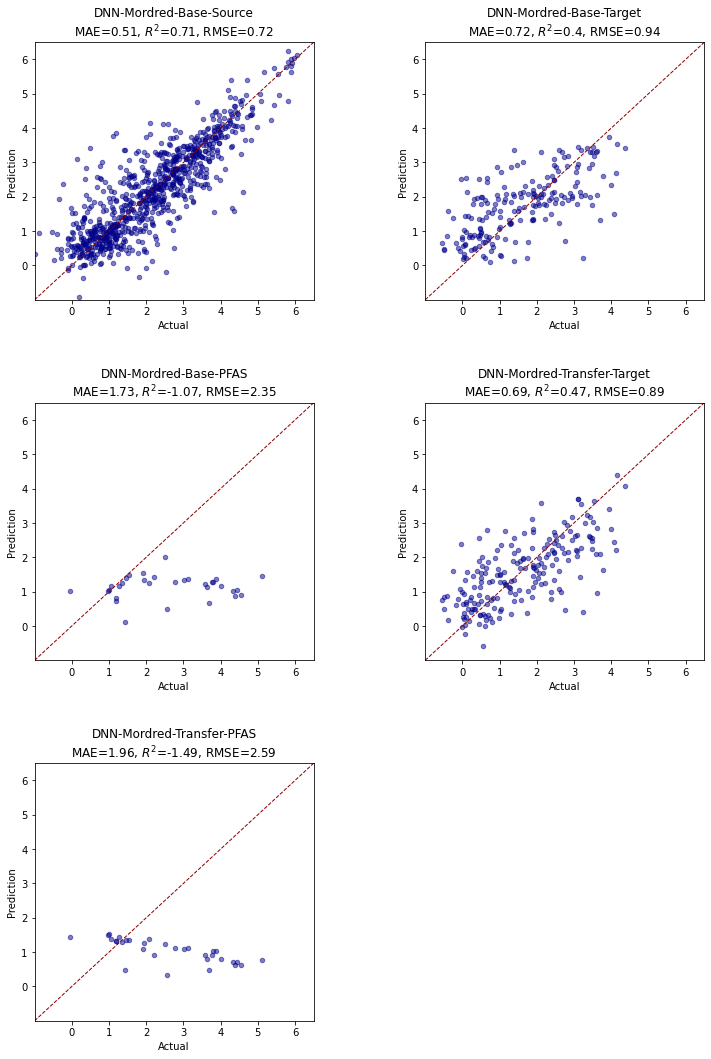

In [16]:
regression_plot('p')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


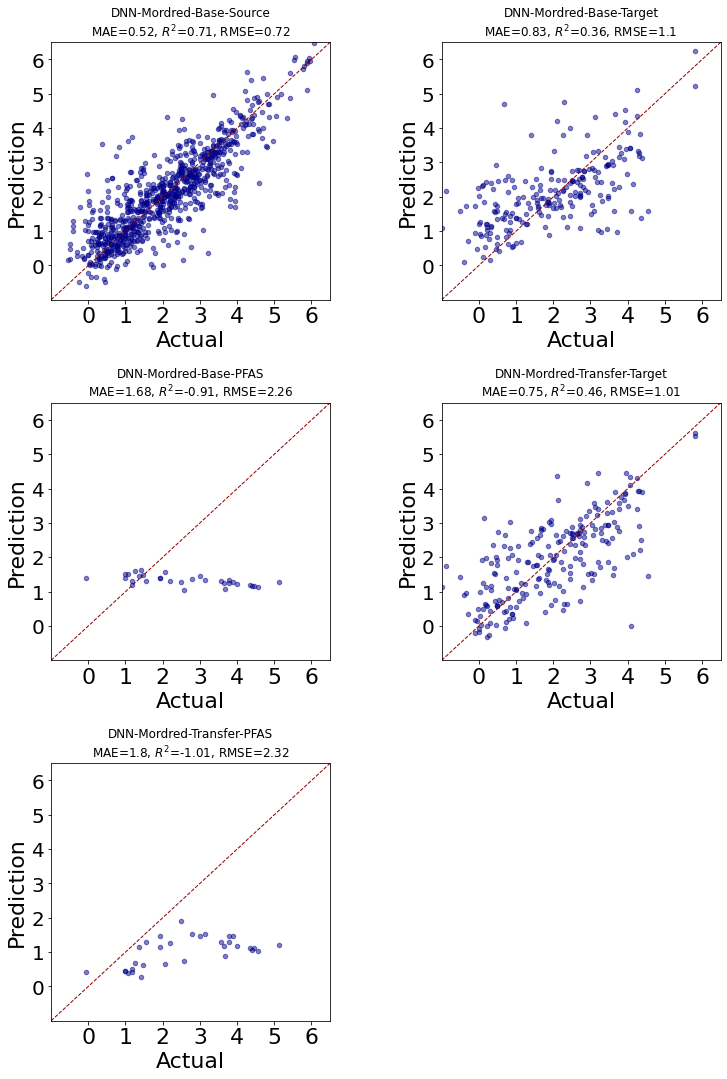

In [21]:
regression_plot('m')

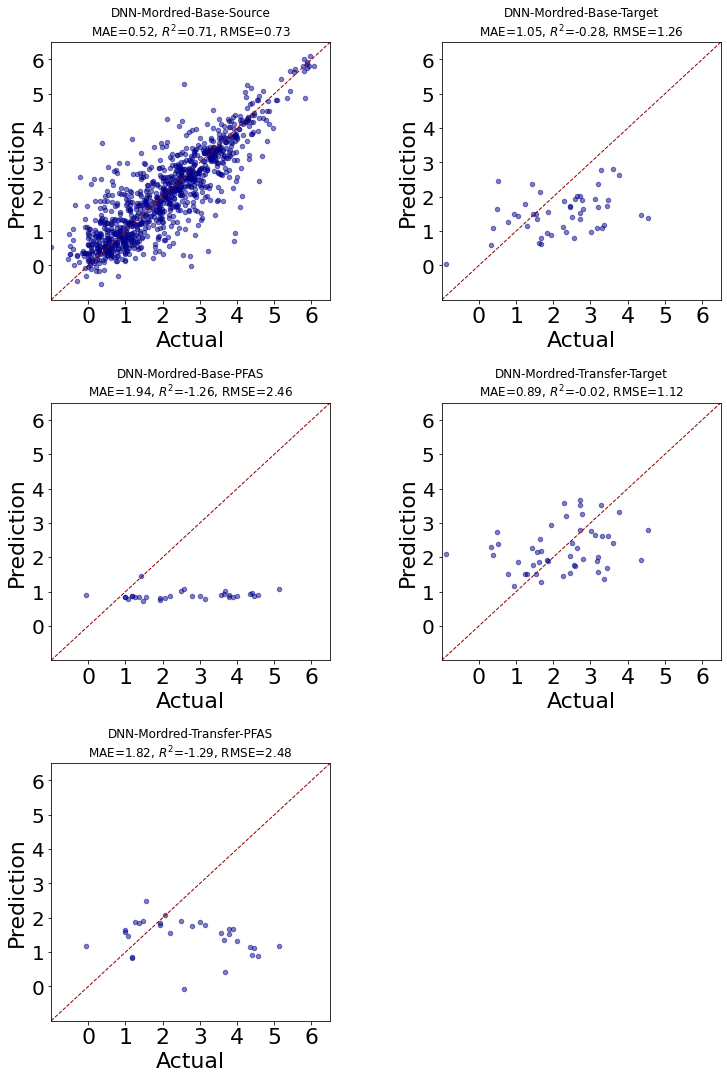

In [25]:
regression_plot('cf')

In [ ]:
# Notes
# Jeremy:
# What to explore:
# model architecture - optimize on source training set or combined source + target data
# mainly optimized transfer learning step
# best now is optimize on source training set

# hyperparameters:
# reinitializing layers, freezing layers, reusing previously optimized parameters
# learning rate, scheduling, number of training epochs
# literature search for more

# cross validation
# not just for baseline comparisons, important for instability and bias on training set
# source task has 5 folds, target training set has 5 folds - pair together
# provide cross validated mean metrics

# final global validation - can use all 5 models as ensemble to predict - maybe even use log likelihood
# or retrain model and use entire dataset

# in the end: null hypothesis is there is no significant translation on proximal to global validation set
# alt hypothesis, proximal dataset can be used


# save neural network weights from earlier as checkpoint
# adjust learning rate, reinitialize weights, freezing weights

# option to freeze + reinitialize last X hidden layers

# save model from each fold on data, import those to next cross validation
# transfer learning happens on same group of pfas-prox datapoints for each of these folds

# scaling recommended done on ENTIRE dataset so that can be used before or after training!